# BL 일간 리밸런싱 백테스트
- 기존 Ridge + Black-Litterman 코드를 재활용
- 일별 리밸런싱 포트폴리오 성과(샤프, MDD)와 시각화


In [16]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **kwargs):
        return x

import warnings
warnings.filterwarnings("ignore")


In [26]:
# =========================
# 사용자가 조정할 파라미터
# =========================
TRAIN_END_DATE = "2020-12-31"
RIDGE_ALPHA = 10.0

EMBEDDING_PATH = "data/kospidaq_embeddings_KR_FinBERT.xlsx"
RETURN_PATH    = "data/report_return_mapping.xlsx"

RETURN_COLS = [f"log_return_{i}" for i in range(11)]
BEST_RETURN = "log_return_1"  # None이면 자동 선택

ADJ_CLOSE_PATH = "data/adj_close_wide_2014_2026.xlsx"
MCAP_PATH      = "data/market_cap_2014_2025.xlsx"

WINDOW = 252
MIN_COVERAGE = 0.90
RISK_AVERSION = 2.5
TAU = 0.025  # 자동: 1 / n (일별 유니버스 자산수)

BACKTEST_START_DATE = None  # None이면 TRAIN_END_DATE 이후 첫 날짜
BACKTEST_END_DATE   = None  # None이면 가능한 마지막 날짜

LONG_ONLY = True
WEIGHT_CLIP = None  # 예: 0.05

TRANSACTION_COST_BPS = 0.0
ANNUALIZATION = 252


## 데이터 로드


In [5]:
df_embed = pd.read_excel(EMBEDDING_PATH)
df_ret = pd.read_excel(RETURN_PATH)

print(df_embed.shape)
print(df_ret.shape)

(62450, 770)
(62450, 14)


## 컬럼 선택 및 집계


In [18]:
embedding_cols = [c for c in df_embed.columns if c.startswith("embedding_")]

df = pd.concat(
    [
        df_embed[["date", "ticker"] + embedding_cols],
        df_ret[["ticker_code"] + RETURN_COLS],
    ],
    axis=1
)

df["date"] = pd.to_datetime(df["date"])

group_cols = ["date", "ticker_code"]

agg_dict = {c: "mean" for c in embedding_cols}
for c in RETURN_COLS:
    agg_dict[c] = "mean"

df_agg = (
    df
    .groupby(group_cols, as_index=False)
    .agg(agg_dict)
)

df_agg.head()


,date,ticker_code,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,log_return_1,log_return_2,log_return_3,log_return_4,log_return_5,log_return_6,log_return_7,log_return_8,log_return_9,log_return_10
0,2013-08-16,001040,0.150668,0.293588,0.174383,0.794043,-0.252831,0.999297,0.656330,1.204585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-08-16,003550,0.225724,0.500187,-0.165939,0.428608,-0.013055,0.300799,0.537054,0.922616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-08-16,004170,-0.480561,0.852025,-0.089869,1.137384,0.301496,0.511020,0.587942,1.060067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-08-16,004370,0.036889,0.559823,-0.007186,0.865696,0.127294,0.388543,0.498597,0.776847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-08-16,005180,-0.395822,0.556432,-0.179259,1.056218,0.058105,0.780324,0.507971,0.816543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Ridge 평가 및 예측


In [19]:
def run_ridge_full_eval(
    df,
    embedding_cols,
    target_return,
    train_end_date,
    alpha=10.0
):
    """
    Ridge regression with time-based holdout.
    Returns train/test R2 and MSE.
    """
    df_tmp = df.dropna(subset=[target_return]).copy()

    train_mask = df_tmp["date"] <= train_end_date
    test_mask  = df_tmp["date"] > train_end_date

    X_train = df_tmp.loc[train_mask, embedding_cols].values
    y_train = df_tmp.loc[train_mask, target_return].values

    X_test  = df_tmp.loc[test_mask, embedding_cols].values
    y_test  = df_tmp.loc[test_mask, target_return].values

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=alpha))
    ])

    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    return {
        "target": target_return,
        "n_train": len(y_train),
        "n_test": len(y_test),
        "train_r2": r2_score(y_train, y_pred_train),
        "test_r2": r2_score(y_test, y_pred_test),
        "train_mse": mean_squared_error(y_train, y_pred_train),
        "test_mse": mean_squared_error(y_test, y_pred_test),
    }

results = []

for ret in RETURN_COLS:
    out = run_ridge_full_eval(
        df=df_agg,
        embedding_cols=embedding_cols,
        target_return=ret,
        train_end_date=TRAIN_END_DATE,
        alpha=RIDGE_ALPHA
    )
    results.append(out)

df_eval = (
    pd.DataFrame(results)
    .sort_values("test_r2", ascending=False)
    .reset_index(drop=True)
)

if BEST_RETURN is None:
    BEST_RETURN = df_eval.loc[0, "target"]

df_eval[
    ["target", "train_r2", "test_r2", "train_mse", "test_mse", "n_train", "n_test"]
]


,target,train_r2,test_r2,train_mse,test_mse,n_train,n_test
0,log_return_0,0.100399,-0.005161,0.001158,0.001597,15482,21897
1,log_return_9,0.063119,-0.047872,0.005612,0.007703,15500,21865
2,log_return_8,0.061467,-0.047965,0.005134,0.006947,15500,21879
3,log_return_7,0.062733,-0.050184,0.004659,0.006153,15500,21889
4,log_return_6,0.061822,-0.052376,0.004183,0.005341,15500,21902
5,log_return_10,0.064174,-0.052706,0.006184,0.008442,15500,21852
6,log_return_5,0.064223,-0.055971,0.003535,0.004522,15500,21902
7,log_return_3,0.063193,-0.057891,0.002254,0.002839,15500,21902
8,log_return_4,0.063059,-0.060567,0.002984,0.003666,15500,21902
9,log_return_2,0.066544,-0.064394,0.001603,0.001959,15500,21902


In [20]:
def run_ridge_and_predict(
    df,
    embedding_cols,
    target_return,
    train_end_date,
    alpha=10.0
):
    df_tmp = df.dropna(subset=[target_return]).copy()

    train_mask = df_tmp["date"] <= train_end_date
    test_mask  = df_tmp["date"] > train_end_date

    X_train = df_tmp.loc[train_mask, embedding_cols].values
    y_train = df_tmp.loc[train_mask, target_return].values
    X_test  = df_tmp.loc[test_mask, embedding_cols].values

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=alpha))
    ])

    model.fit(X_train, y_train)

    df_tmp.loc[train_mask, "pred_return"] = model.predict(X_train)
    df_tmp.loc[test_mask,  "pred_return"] = model.predict(X_test)

    return df_tmp, model

df_pred, ridge_model = run_ridge_and_predict(
    df=df_agg,
    embedding_cols=embedding_cols,
    target_return=BEST_RETURN,
    train_end_date=TRAIN_END_DATE,
    alpha=RIDGE_ALPHA
)

df_view = (
    df_pred
    .groupby(["date", "ticker_code"], as_index=False)
    .agg({"pred_return": "mean"})
)

df_view.head()


,date,ticker_code,pred_return
0,2014-01-02,009150,0.003608
1,2014-01-02,036460,0.001110
2,2014-01-02,051900,-0.001270
3,2014-01-02,052690,-0.001385
4,2014-01-03,004370,-0.008470


## 가격/시총 로드


In [9]:
from pathlib import Path

ADJ_CLOSE_PATH = Path(ADJ_CLOSE_PATH)
MCAP_PATH      = Path(MCAP_PATH)

px = pd.read_excel(ADJ_CLOSE_PATH, index_col=0)
mc = pd.read_excel(MCAP_PATH, index_col=0)

px.index = pd.to_datetime(px.index)
mc.index = pd.to_datetime(mc.index)

# ticker_code를 문자열로 통일(005930 같은)
px.columns = px.columns.astype(str).str.zfill(6)
mc.columns = mc.columns.astype(str).str.zfill(6)

px = px.sort_index()
mc = mc.sort_index()

(px.shape, mc.shape, px.index.min(), px.index.max(), mc.index.max())


((2951, 2761),
 (2945, 2761),
 Timestamp('2014-01-02 00:00:00'),
 Timestamp('2026-01-09 00:00:00'),
 Timestamp('2025-12-30 00:00:00'))

## BL 함수


In [21]:
def compute_log_returns(price_wide: pd.DataFrame) -> pd.DataFrame:
    r = np.log(price_wide / price_wide.shift(1))
    return r

from sklearn.covariance import LedoitWolf

def compute_prior_at_date(
    view_date: pd.Timestamp,
    px_wide: pd.DataFrame,
    mc_wide: pd.DataFrame,
    window: int = 252,
    min_coverage: float = 0.90,
    risk_aversion: float = 2.5,
    ret_wide: pd.DataFrame = None
):
    """
    Returns:
      - tickers_univ: prior에 포함되는 종목 리스트 (정렬된 순서)
      - Sigma: (N,N) 공분산 (Ledoit-Wolf)
      - Pi: (N,) 내재 기대수익률
      - w_mkt: (N,) 시총가중치
    """
    view_date = pd.to_datetime(view_date)

    # 시총 데이터 끝나는 날짜 체크
    if view_date not in mc_wide.index:
        raise ValueError(f"market cap에 {view_date.date()}가 없습니다. (mc max={mc_wide.index.max().date()})")

    # 수익률 계산 (외부에서 미리 계산한 경우 재사용)
    if ret_wide is None:
        ret = compute_log_returns(px_wide)
    else:
        ret = ret_wide

    # view_date 기준, 직전 window일 수익률 구간 뽑기
    if view_date not in ret.index:
        raise ValueError(f"가격/수익률 데이터에 {view_date.date()}가 없습니다.")

    end_loc = ret.index.get_loc(view_date)
    start_loc = end_loc - window + 1
    if start_loc < 0:
        raise ValueError("윈도우가 너무 깁니다. 과거 데이터가 부족합니다.")

    ret_win = ret.iloc[start_loc:end_loc+1]  # (window, #tickers)

    # 커버리지 조건 (유효 관측치 비율)
    min_obs = int(np.ceil(window * min_coverage))
    valid_obs = ret_win.notna().sum(axis=0)
    tickers_cov = valid_obs[valid_obs >= min_obs].index

    # 당일 시총 존재 종목
    mcap_t = mc_wide.loc[view_date]
    tickers_mcap = mcap_t.dropna().index

    # 최종 prior 유니버스
    tickers_univ = sorted(list(set(tickers_cov).intersection(set(tickers_mcap))))
    if len(tickers_univ) < 2:
        raise ValueError("prior 유니버스가 너무 작습니다. (커버리지/시총 결측 확인)")

    # 공분산: 수익률 윈도우에서 유니버스만 뽑고, 결측은 행 단위로 제거
    X = ret_win[tickers_univ]
    X = X.dropna(axis=0, how="any")  # LedoitWolf는 NaN 허용 안 함

    if len(X) < min_obs:
        # dropna로 너무 줄어들면(공통 거래일 부족) 기준을 더 느슨하게 하거나 다른 처리 필요
        raise ValueError(f"공통 관측치가 부족합니다: {len(X)}행만 남음 (min_obs={min_obs})")

    lw = LedoitWolf().fit(X.values)
    Sigma = lw.covariance_

    # 시총가중치
    mcap_vec = mc_wide.loc[view_date, tickers_univ].values.astype(float)
    w_mkt = mcap_vec / np.nansum(mcap_vec)

    # 내재 기대수익률
    Pi = risk_aversion * (Sigma @ w_mkt)

    return tickers_univ, Sigma, Pi, w_mkt


def align_view_to_prior(
    df_view: pd.DataFrame,      # columns: date, ticker_code, pred_return
    view_date: pd.Timestamp,
    tickers_univ: list,
    df_view_by_date: dict = None
):
    view_date = pd.to_datetime(view_date)

    if df_view_by_date is not None:
        tmp = df_view_by_date.get(view_date)
        if tmp is None:
            raise ValueError(f"view에 {view_date.date()}가 없습니다.")
        tmp = tmp.copy()
    else:
        tmp = df_view[df_view["date"] == view_date].copy()

    tmp["ticker_code"] = tmp["ticker_code"].astype(str).str.zfill(6)

    view_tickers_all = set(tmp["ticker_code"].unique())
    prior_tickers = set(tickers_univ)

    # prior 기준으로 view 필터
    tmp = tmp[tmp["ticker_code"].isin(prior_tickers)]

    view_tickers = sorted(tmp["ticker_code"].unique())
    missing_in_prior = sorted(list(view_tickers_all - prior_tickers))
    missing_in_view  = sorted(list(prior_tickers - set(view_tickers)))

    if len(view_tickers) < 1:
        raise ValueError("교집합 종목이 없습니다. (view/prior 정합성 문제)")

    # view 순서로 Q 만들기
    tmp_c = tmp.sort_values("ticker_code")
    Q = tmp_c["pred_return"].values
    tickers_view = tmp_c["ticker_code"].values

    return {
        "tickers_view": tickers_view,
        "Q": Q,
        "missing_in_prior": missing_in_prior,  # view는 있는데 prior에 없는 종목
        "missing_in_view": missing_in_view,    # prior는 있는데 view가 없는 종목
        "n_view": len(view_tickers),
        "n_prior": len(prior_tickers),
        "n_common": len(view_tickers),
    }


def slice_prior_to_common(tickers_univ, Sigma, Pi, w_mkt, tickers_common):
    # tickers_common: array-like of ticker codes (sorted)
    idx_map = {t:i for i,t in enumerate(tickers_univ)}
    idx = np.array([idx_map[t] for t in tickers_common], dtype=int)

    Sigma_c = Sigma[np.ix_(idx, idx)]
    Pi_c = Pi[idx]
    w_c = w_mkt[idx]

    return Sigma_c, Pi_c, w_c


def compute_oos_mse_for_omega(df_pred, target_return, train_end_date):
    mask = df_pred["date"] > pd.to_datetime(train_end_date)
    y_true = df_pred.loc[mask, target_return].values
    y_pred = df_pred.loc[mask, "pred_return"].values
    return mean_squared_error(y_true, y_pred)


def black_litterman_posterior(Pi, Sigma, P, Q, Omega, tau=0.05):
    Sigma_t = tau * Sigma

    A = np.linalg.inv(Sigma_t) + P.T @ np.linalg.inv(Omega) @ P
    b = np.linalg.inv(Sigma_t) @ Pi + P.T @ np.linalg.inv(Omega) @ Q

    mu_bl = np.linalg.solve(A, b)  # inv(A)@b 보다 안정적
    return mu_bl


def compute_bl_weights(mu_bl, Sigma, risk_aversion, long_only=True, weight_clip=None):
    # 블랙-리터만 기대수익률을 평균-분산 가중치로 변환
    w = np.linalg.solve(Sigma, mu_bl) / risk_aversion

    if long_only:
        w = np.clip(w, 0.0, None)

    if weight_clip is not None:
        if long_only:
            w = np.clip(w, 0.0, weight_clip)
        else:
            w = np.clip(w, -weight_clip, weight_clip)

    s = w.sum()
    if np.isclose(s, 0):
        w = np.ones_like(w) / len(w)
    else:
        w = w / s

    return w


def calc_mdd(cum):
    roll_max = np.maximum.accumulate(cum)
    dd = cum / roll_max - 1.0
    return dd.min(), dd


## 일간 리밸런싱 백테스트


In [31]:
# 수익률 (단순수익률)
ret_log = compute_log_returns(px)
ret_simple = np.exp(ret_log) - 1.0

# view 캐시 (속도 개선)
df_view_by_date = {pd.to_datetime(d): g for d, g in df_view.groupby("date")}

# 백테스트 날짜 범위
all_view_dates = pd.to_datetime(df_view["date"].unique())
all_view_dates = pd.DatetimeIndex(all_view_dates).sort_values()

if BACKTEST_START_DATE is None:
    start_base = pd.to_datetime(TRAIN_END_DATE)
    start_candidates = all_view_dates[all_view_dates > start_base]
    if len(start_candidates) == 0:
        raise ValueError("BACKTEST_START_DATE를 찾을 수 없습니다. 날짜 범위를 확인하세요.")
    backtest_start = start_candidates[0]
else:
    backtest_start = pd.to_datetime(BACKTEST_START_DATE)

if BACKTEST_END_DATE is None:
    backtest_end = all_view_dates[-1]
else:
    backtest_end = pd.to_datetime(BACKTEST_END_DATE)

view_dates = [d for d in all_view_dates if (d >= backtest_start) and (d <= backtest_end)]

# Omega 계산용 OOS MSE (전체 고정)
oos_mse = compute_oos_mse_for_omega(
    df_pred=df_pred,
    target_return=BEST_RETURN,
    train_end_date=TRAIN_END_DATE
)

results = []
weights_hist = []

ret_index = ret_simple.index
next_date_map = {ret_index[i]: ret_index[i + 1] for i in range(len(ret_index) - 1)}

prev_w = None
prev_tickers = None

for view_date in tqdm(view_dates, desc="Backtest", total=len(view_dates)):
    try:
        tickers_univ, Sigma, Pi, w_mkt = compute_prior_at_date(
            view_date=view_date,
            px_wide=px,
            mc_wide=mc,
            window=WINDOW,
            min_coverage=MIN_COVERAGE,
            risk_aversion=RISK_AVERSION,
            ret_wide=ret_log
        )

        aligned = align_view_to_prior(
            df_view=df_view,
            view_date=view_date,
            tickers_univ=tickers_univ,
            df_view_by_date=df_view_by_date
        )

        Q = aligned["Q"]
        tickers_view = aligned["tickers_view"]

        n = len(tickers_univ)
        k = len(Q)
        idx_map = {t:i for i,t in enumerate(tickers_univ)}

        P = np.zeros((k, n))
        for i, t in enumerate(tickers_view):
            P[i, idx_map[t]] = 1.0

        tau = 0.025
        Omega = np.eye(k) * oos_mse

        mu_bl = black_litterman_posterior(
            Pi=Pi,
            Sigma=Sigma,
            P=P,
            Q=Q,
            Omega=Omega,
            tau=tau
        )

        w = compute_bl_weights(
            mu_bl=mu_bl,
            Sigma=Sigma,
            risk_aversion=RISK_AVERSION,
            long_only=LONG_ONLY,
            weight_clip=WEIGHT_CLIP
        )

        # 벤치마크: 시총가중치 (전체 유니버스 기준)
        bm_sum = np.sum(w_mkt)
        if np.isclose(bm_sum, 0):
            w_bm = np.ones_like(w_mkt) / len(w_mkt)
        else:
            w_bm = w_mkt / bm_sum

    except Exception:
        continue

    next_date = next_date_map.get(view_date)
    if next_date is None:
        continue

    ret_vec = ret_simple.loc[next_date, tickers_univ].values.astype(float)
    tickers_ret = np.array(tickers_univ)

    if np.isnan(ret_vec).any():
        mask = ~np.isnan(ret_vec)
        if mask.sum() < 2:
            continue
        ret_vec = ret_vec[mask]
        w = w[mask]
        w = w / w.sum()
        w_bm = w_bm[mask]
        w_bm = w_bm / w_bm.sum()
        tickers_ret = tickers_ret[mask]

    turnover = 0.0
    if prev_w is None:
        turnover = np.sum(np.abs(w))
    else:
        if (prev_tickers is not None) and np.array_equal(prev_tickers, tickers_ret):
            turnover = np.sum(np.abs(w - prev_w))
        else:
            turnover = np.sum(np.abs(w))

    cost = turnover * (TRANSACTION_COST_BPS / 10000.0)

    port_ret = float(np.dot(w, ret_vec)) - cost
    bm_ret = float(np.dot(w_bm, ret_vec))

    results.append({
        "view_date": view_date,
        "next_date": next_date,
        "net_ret": port_ret,
        "bm_ret": bm_ret,
        "cost": cost,
        "n_assets": len(w)
    })

    weights_hist.append(
        pd.DataFrame({
            "date": view_date,
            "ticker_code": tickers_ret,
            "weight": w
        })
    )

    prev_w = w
    prev_tickers = tickers_ret

if len(results) == 0:
    df_bt = pd.DataFrame()
    weights_history = pd.DataFrame()
else:
    df_bt = pd.DataFrame(results).sort_values("next_date").set_index("next_date")
    weights_history = pd.concat(weights_hist, ignore_index=True)

df_bt.head()


Backtest: 100%|██████████| 1225/1225 [2:20:50<00:00,  6.90s/it] 


,view_date,net_ret,bm_ret,cost,n_assets
next_date,,,,,
2021-01-05,2021-01-04,0.013822,0.013986,0.0,2164
2021-01-06,2021-01-05,-0.006978,-0.007319,0.0,2164
2021-01-07,2021-01-06,0.017926,0.019020,0.0,2164
2021-01-08,2021-01-07,0.017667,0.035007,0.0,2164
2021-01-11,2021-01-08,-0.009525,-0.001414,0.0,2164


In [32]:
df_bt

,view_date,net_ret,bm_ret,cost,n_assets
next_date,,,,,
2021-01-05,2021-01-04,0.013822,0.013986,0.0,2164
2021-01-06,2021-01-05,-0.006978,-0.007319,0.0,2164
2021-01-07,2021-01-06,0.017926,0.019020,0.0,2164
2021-01-08,2021-01-07,0.017667,0.035007,0.0,2164
2021-01-11,2021-01-08,-0.009525,-0.001414,0.0,2164
...,...,...,...,...,...
2025-12-24,2025-12-23,-0.002191,-0.002433,0.0,2674
2025-12-26,2025-12-24,0.004448,0.005287,0.0,2674
2025-12-29,2025-12-26,0.003698,0.020658,0.0,2673


## 성과 요약


In [33]:
if df_bt.empty:
    print("백테스트 결과가 없습니다. 날짜/데이터 범위를 확인하세요.")
else:
    def make_summary(ret_series, label):
        cum = (1.0 + ret_series).cumprod()
        mdd, dd = calc_mdd(cum.values)

        ret_std = ret_series.std()
        if ret_std == 0 or np.isnan(ret_std):
            sharpe = np.nan
        else:
            sharpe = (ret_series.mean() / ret_std) * np.sqrt(ANNUALIZATION)

        summary = pd.Series({
            "샤프지수": sharpe,
            "MDD": mdd,
            "누적수익률": cum.iloc[-1] - 1.0,
            "평균일간수익률": ret_series.mean(),
            "일간변동성": ret_std,
            "관측일수": len(ret_series)
        }, name=label)

        return summary, cum, dd

    summary_strat, cum, dd = make_summary(df_bt["net_ret"], "전략")
    df_bt["cum"] = cum
    df_bt["drawdown"] = dd

    if "bm_ret" in df_bt.columns:
        summary_bm, bm_cum, bm_dd = make_summary(df_bt["bm_ret"], "벤치마크")
        df_bt["bm_cum"] = bm_cum
        df_bt["bm_drawdown"] = bm_dd
        summary = pd.concat([summary_strat, summary_bm], axis=1)
    else:
        summary = summary_strat


summary


,전략,벤치마크
샤프지수,0.725924,0.475179
MDD,-0.255602,-0.344384
누적수익률,0.804019,0.412874
평균일간수익률,0.000556,0.000351
일간변동성,0.012159,0.011732
관측일수,1225.000000,1225.000000


## 시각화


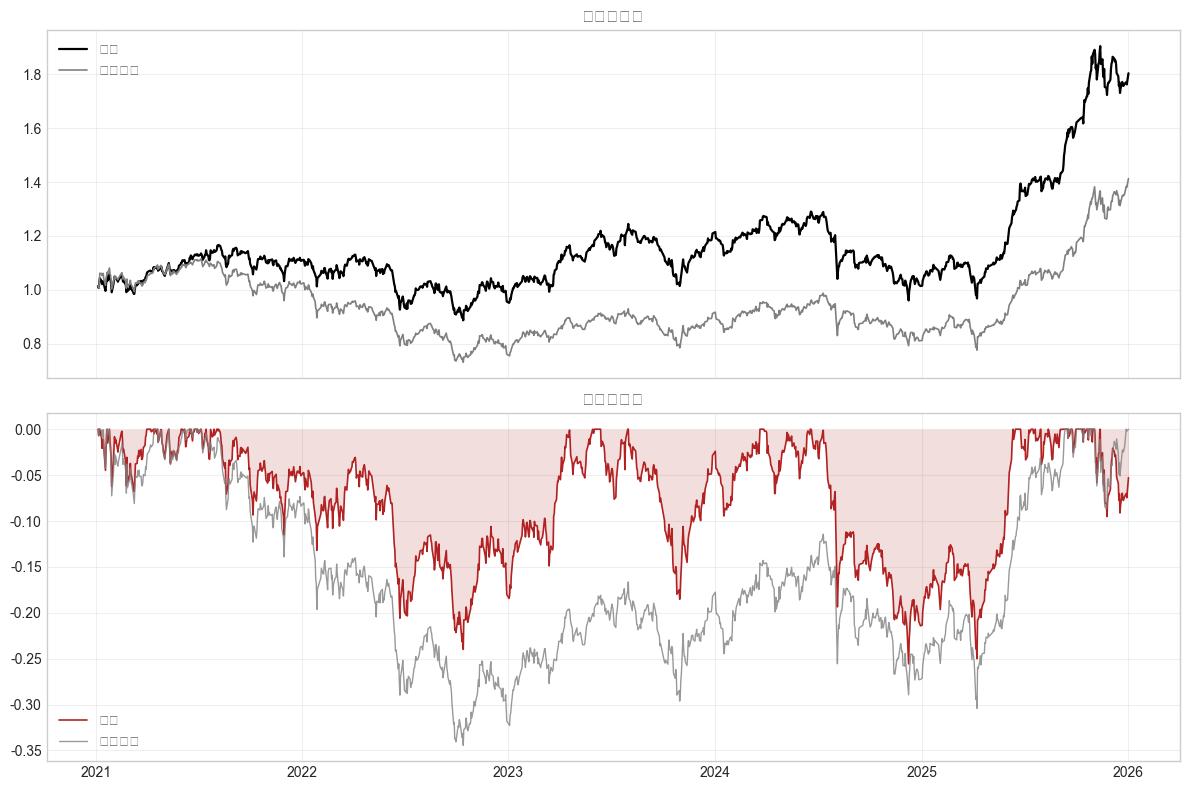

In [34]:
if not df_bt.empty:
    import matplotlib as mpl
    import matplotlib.font_manager as fm

    # 한글 폰트 설정
    preferred_fonts = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    available_fonts = {f.name for f in fm.fontManager.ttflist}
    for font in preferred_fonts:
        if font in available_fonts:
            mpl.rcParams["font.family"] = font
            break
    mpl.rcParams["axes.unicode_minus"] = False

    plt.style.use("seaborn-v0_8-whitegrid")

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(df_bt.index, df_bt["cum"], color="black", lw=1.6, label="전략")
    if "bm_cum" in df_bt.columns:
        axes[0].plot(df_bt.index, df_bt["bm_cum"], color="gray", lw=1.2, label="벤치마크")
        axes[0].legend()
    axes[0].set_title("누적수익률")
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(df_bt.index, df_bt["drawdown"], color="firebrick", lw=1.2, label="전략")
    axes[1].fill_between(df_bt.index, df_bt["drawdown"], 0, color="firebrick", alpha=0.15, linewidth=0)
    if "bm_drawdown" in df_bt.columns:
        axes[1].plot(df_bt.index, df_bt["bm_drawdown"], color="gray", lw=1.0, alpha=0.8, label="벤치마크")
        axes[1].legend()
    axes[1].set_title("드로우다운")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
